# Introduction

This is the process by which I generated an AutoRegressive Integrated Moving Average (ARIMA) time series model to determine the best zip codes for investment. The model was generated using historical median house sales from Zillow.

The data contains monthly median housing sales for zip codes across the entire United States, going back as far as 1996.

What follows are my steps that lead me to my final model.

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
import itertools

import warnings
warnings.filterwarnings('ignore')

In [2]:
color1= '#28A855'
color2= '#DB8925'

# Data Preprocessing

#### Importing Data

In [3]:
data = pd.read_csv('zillow_data.csv')

In [4]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Data Preprocessing

In [5]:
df = pd.melt(data, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
                           'SizeRank'],
             var_name='Date', value_name='Median_Housing_Sales')

df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Median_Housing_Sales
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04,77300.0


In [6]:
print("Length of df: {}".format(len(df)))
print("Number of Zipcodes: {}".format(len(df.RegionName.unique())))
print("Number of Cities: {}".format(len(df.City.unique())))
print("Number of Metros: {}".format(len(df.Metro.unique())))
print("Number of Months: {}".format(len(df.Date.unique())))

Length of df: 3901595
Number of Zipcodes: 14723
Number of Cities: 7554
Number of Metros: 702
Number of Months: 265


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901595 entries, 0 to 3901594
Data columns (total 9 columns):
RegionID                int64
RegionName              int64
City                    object
State                   object
Metro                   object
CountyName              object
SizeRank                int64
Date                    object
Median_Housing_Sales    float64
dtypes: float64(1), int64(3), object(5)
memory usage: 267.9+ MB


In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3901595 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
RegionID                int64
RegionName              int64
City                    object
State                   object
Metro                   object
CountyName              object
SizeRank                int64
Median_Housing_Sales    float64
dtypes: float64(1), int64(3), object(4)
memory usage: 267.9+ MB


In [9]:
#RegionID looks to be a unique identifier for Zillow, so I have removed it
df.drop(columns=['RegionID'], inplace=True)
df.rename(columns= {'RegionName': 'Zipcode'}, inplace=True)

In [10]:
df.head()

,Zipcode,City,State,Metro,CountyName,SizeRank,Median_Housing_Sales
Date,,,,,,,
1996-04-01,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,79936,El Paso,TX,El Paso,El Paso,5,77300.0


This data goes all the way back to April 1996, but we won't need data that old. We'll want to look at data from 2009 onward, as 2008 was the housing bubble burst and will likely lead to some misleading data and assumptions.

In [11]:
df_new = df['2009-01':]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1648976 entries, 2009-01-01 to 2018-04-01
Data columns (total 7 columns):
Zipcode                 1648976 non-null int64
City                    1648976 non-null object
State                   1648976 non-null object
Metro                   1532160 non-null object
CountyName              1648976 non-null object
SizeRank                1648976 non-null int64
Median_Housing_Sales    1629940 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 100.6+ MB


In [12]:
zip_count = df_new.groupby(['Zipcode'])['Median_Housing_Sales'].count()
zip_df = zip_count.reset_index()
zip_df['Median_Housing_Sales'].unique()

array([112,  46,  94,  70, 106,  52,  76,  82,  64,  88,  58,  98, 100])

In [13]:
print("Total Zipcodes: {}".format(len(zip_df)))
print("Number of Zipcodes all data (265): {}".format(len(zip_df[zip_df['Median_Housing_Sales'] == 112])))
print("Number of Zipcodes missing data: {}".format(len(zip_df[zip_df['Median_Housing_Sales'] != 112])))

Total Zipcodes: 14723
Number of Zipcodes all data (265): 14136
Number of Zipcodes missing data: 587


There are 112 months in our truncated dataset, so a zipcode needs to have the same number of counts of `Median_Housing_Sales` values for it to have a complete set of data. For those that are missing values, I will remove them.

In [14]:
zip_df.columns

Index(['Zipcode', 'Median_Housing_Sales'], dtype='object')

In [15]:
zips_missing = list(zip_df[zip_df['Median_Housing_Sales'] != 112]['Zipcode'])

clean_df = df_new[~df_new['Zipcode'].isin(zips_missing)]

# EDA and Visualization

### 1. Profit Margin

The first thing I want to look at is the profit margin in median housing sales over time. Had we bought the house in January of 2009, what would our profit margin be if we sold it in April of 2018? To do this, I need to separate out the median housing sales for the first date on record, the last date on record, and then combine them by zip code. It's then a simple calculation for profit margin:

**Profit Margin** = 1 - (*price paid for house*)/(*price house sold*)

In [16]:
df_start = clean_df['2009-01']
df_start.reset_index(inplace=True)
df_start.drop(columns=['Date'], inplace=True)
df_start.rename(columns = {'Median_Housing_Sales':'Price_paid'}, inplace=True)

In [17]:
df_end = clean_df['2018-04']
df_end.reset_index(inplace=True)
df_end.rename(columns = {'Median_Housing_Sales':'Price_sold'}, inplace=True)
df_end = df_end[['Zipcode', 'Price_sold']]

In [18]:
#combining datasets
df_pm = pd.merge(df_start, df_end, how='left', on='Zipcode')
df_pm['Profit_margin'] = (1 - (df_pm.Price_paid/df_pm.Price_sold))*100
df_pm.sort_values('Profit_margin', ascending=False).head()

,Zipcode,City,State,Metro,CountyName,SizeRank,Price_paid,Price_sold,Profit_margin
5665,94301,Palo Alto,CA,San Jose,Santa Clara,5739,1726900.0,4818400.0,64.160302
1148,11222,New York,NY,New York,Kings,1156,633600.0,1721100.0,63.186334
2560,94043,Mountain View,CA,San Jose,Santa Clara,2581,764700.0,2074900.0,63.145212
472,11216,New York,NY,New York,Kings,476,610900.0,1598700.0,61.787703
6473,15201,Pittsburgh,PA,Pittsburgh,Allegheny,6564,70900.0,185200.0,61.717063


In [19]:
#averaging profit margin by metro
df_pm_met = df_pm.groupby(['Metro', 'State'])['Profit_margin'].mean()
df_pm_met = (df_pm_met.reset_index() 
              .rename(columns={'Profit_margin':'Mean_Profit_margin'})
              .sort_values('Mean_Profit_margin', ascending=False))
df_pm_met.head(10)

,Metro,State,Mean_Profit_margin
770,Williston,ND,60.884956
633,San Jose,CA,50.655149
452,Merced,CA,44.990071
280,Greeley,CO,44.731013
632,San Francisco,CA,43.030436
188,Denver,CO,42.059354
468,Modesto,CA,40.442855
70,Bismarck,ND,40.282324
692,Stockton,CA,40.159824
191,Dickinson,ND,38.615889


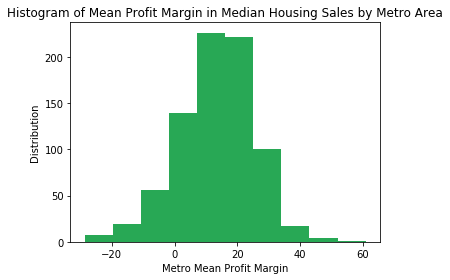

Median Profit Margin: 14.42
Mean Profit Margin: 13.36


In [20]:
#Distribution of Mean Profit Margin for Metro Areas
x = df_pm_met['Mean_Profit_margin']

fig1, ax1 = plt.subplots()
ax1.hist(x, color=color1)
ax1.set_xlabel('Metro Mean Profit Margin')
ax1.set_ylabel('Distribution')
ax1.set_title('Histogram of Mean Profit Margin in Median Housing Sales by Metro Area')

fig1.tight_layout()
plt.show()
print('Median Profit Margin: {}'.format(round(x.median(), 2)))
print('Mean Profit Margin: {}'.format(round(x.mean(), 2)))

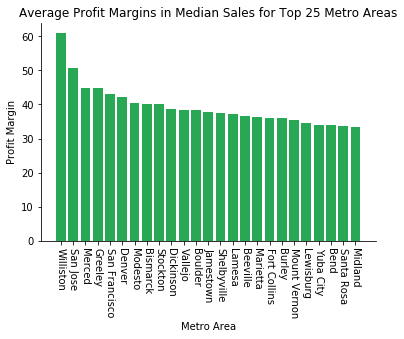

In [21]:
#Bar chart of top 25
top_25_pm = df_pm_met.iloc[0:25]

x = top_25_pm['Metro']
y = top_25_pm['Mean_Profit_margin']

fig2, ax2 = plt.subplots()
ax2.bar(x,y, color=color1)
ax2.set_xlabel('Metro Area')
ax2.set_ylabel('Profit Margin')
ax2.set_title('Average Profit Margins in Median Sales for Top 25 Metro Areas')
plt.xticks(rotation=270)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.show()

#### Top 10 metro areas based on profit margin

In [22]:
#selecting top 10 metro areas, then filtering cleaned dataframe
top_10_metro = list(top_25_pm[0:10]['Metro'])

top_metro_df = clean_df[clean_df['Metro'].isin(top_10_metro)]

In [23]:
#creating average of median housing sales for each metro
by_metro = pd.DataFrame(top_metro_df.groupby(['Date', 'Metro'])['Median_Housing_Sales'].mean())
by_metro.reset_index(inplace=True)
by_metro.set_index('Date', inplace=True)
by_metro_wide = by_metro.pivot(columns='Metro', values='Median_Housing_Sales')

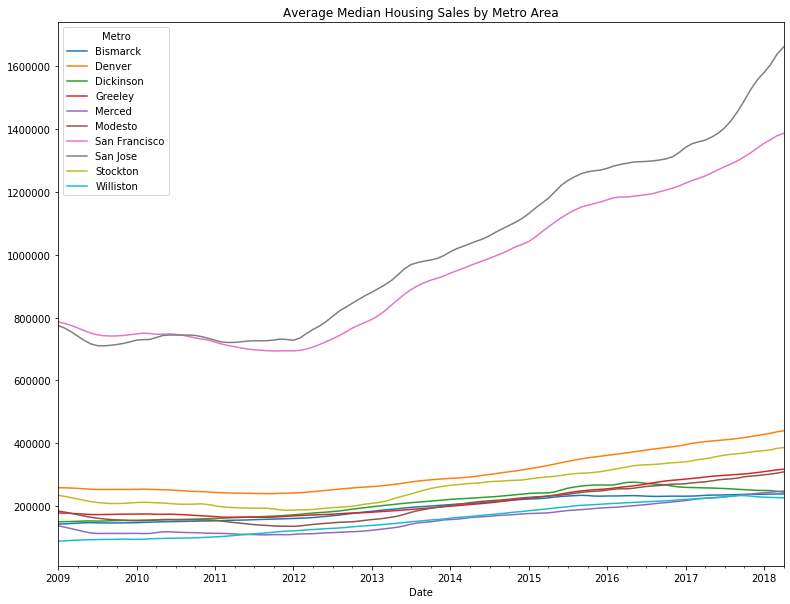

In [24]:
by_metro_wide.plot(figsize = (13,10), legend=True)
plt.title('Average Median Housing Sales by Metro Area')
plt.savefig('pm_metro_mediansales.png')
plt.show()

#### Profit Margin by Metro

When calculating the profit margin in median housing sales, you'll find that the average profit margin in median housing sales by metro area was 13.4% (median 14.4%) over the past 9 years. Not accounting for inflation, the following metro areas exhibited the largest profit margins in median housing sales:

In [25]:
df_pm_met.head(10)

,Metro,State,Mean_Profit_margin
770,Williston,ND,60.884956
633,San Jose,CA,50.655149
452,Merced,CA,44.990071
280,Greeley,CO,44.731013
632,San Francisco,CA,43.030436
188,Denver,CO,42.059354
468,Modesto,CA,40.442855
70,Bismarck,ND,40.282324
692,Stockton,CA,40.159824
191,Dickinson,ND,38.615889


#### Profit Margin by Zip code

Although the analysis of profit margin by metro areas is interesting, the question we're focused on is which zip codes are best for investing. As some zip codes with high profit margin may be located in metro areas that didn't do as well as these ten, we need run a similar analysis looking at just zip codes.

In [26]:
top_10_pm = df_pm.sort_values('Profit_margin', ascending=False).head(10)
top_10_pm_zips = list(top_10_pm['Zipcode'])
top_10_pm

,Zipcode,City,State,Metro,CountyName,SizeRank,Price_paid,Price_sold,Profit_margin
5665,94301,Palo Alto,CA,San Jose,Santa Clara,5739,1726900.0,4818400.0,64.160302
1148,11222,New York,NY,New York,Kings,1156,633600.0,1721100.0,63.186334
2560,94043,Mountain View,CA,San Jose,Santa Clara,2581,764700.0,2074900.0,63.145212
472,11216,New York,NY,New York,Kings,476,610900.0,1598700.0,61.787703
6473,15201,Pittsburgh,PA,Pittsburgh,Allegheny,6564,70900.0,185200.0,61.717063
1781,94040,Mountain View,CA,San Jose,Santa Clara,1792,1093700.0,2839500.0,61.482655
2451,80010,Aurora,CO,Denver,Arapahoe,2471,107000.0,277600.0,61.455331
115,11211,New York,NY,New York,Kings,118,631700.0,1623700.0,61.095030
2433,58801,Williston,ND,Williston,Williams,2453,88400.0,226000.0,60.884956
2140,80204,Denver,CO,Denver,Denver,2156,146900.0,371600.0,60.468245


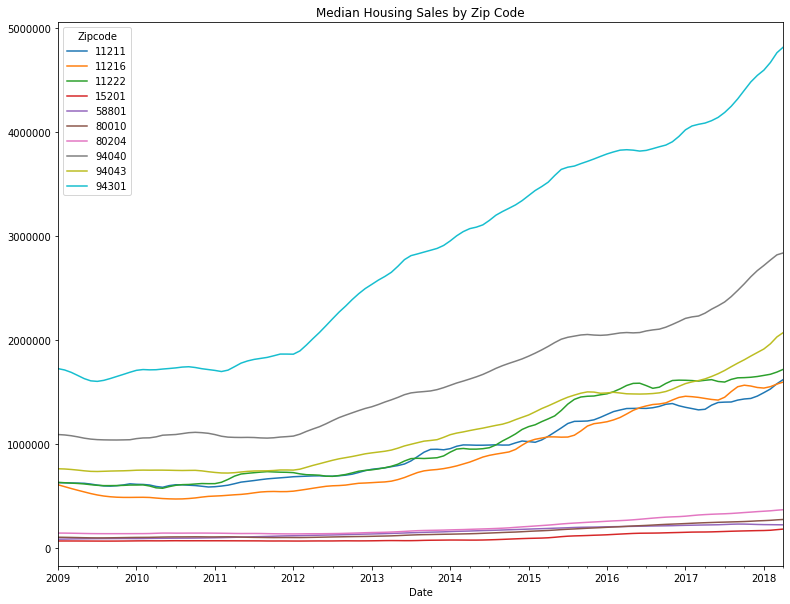

In [27]:
zip_vis_1 = clean_df[clean_df['Zipcode'].isin(top_10_pm_zips)]
zip_vis_1.drop(columns = ['City', 'State', 'Metro', 'CountyName', 'SizeRank'], inplace=True)
zip_wide_1 = zip_vis_1.pivot(columns='Zipcode', values='Median_Housing_Sales')

zip_wide_1.plot(figsize = (13,10), legend=True)
plt.title('Median Housing Sales by Zip Code')
plt.savefig('pm_zip_mediansales.png')
plt.show()

We can see, that by looking only at zip codes, there are quite a few in the New York metro area we would have missed, had we based our choices on which zip codes to investigate further on metro area alone.

### 2. Return on Investment

Using the same dataframes I created for my exploration into profit margins, we'll now take a look at return on investment across metro areas.

In [28]:
df_roi = df_pm.copy()
df_roi['ROI'] = ((df_roi.Price_sold - df_roi.Price_paid)/df_roi.Price_paid)*100
df_roi.head()

,Zipcode,City,State,Metro,CountyName,SizeRank,Price_paid,Price_sold,Profit_margin,ROI
0,60657,Chicago,IL,Chicago,Cook,1,818300.0,1030600.0,20.599651,25.944030
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,202400.0,321800.0,37.103791,58.992095
2,77494,Katy,TX,Houston,Harris,3,246700.0,329900.0,25.219764,33.725172
3,60614,Chicago,IL,Chicago,Cook,4,1065400.0,1307000.0,18.485080,22.676929
4,79936,El Paso,TX,El Paso,El Paso,5,121600.0,121500.0,-0.082305,-0.082237


In [29]:
df_roi_met = df_roi.groupby(['Metro', 'State'])['ROI'].mean()
df_roi_met = (df_roi_met.reset_index() 
              .rename(columns={'ROI':'Mean_ROI'})
              .sort_values('Mean_ROI', ascending=False))
df_roi_met.head(10)

,Metro,State,Mean_ROI
770,Williston,ND,155.656109
633,San Jose,CA,107.459398
280,Greeley,CO,82.892898
452,Merced,CA,82.739365
632,San Francisco,CA,78.109781
188,Denver,CO,76.206190
692,Stockton,CA,68.769423
468,Modesto,CA,68.700254
70,Bismarck,ND,68.344979
730,Vallejo,CA,63.218963


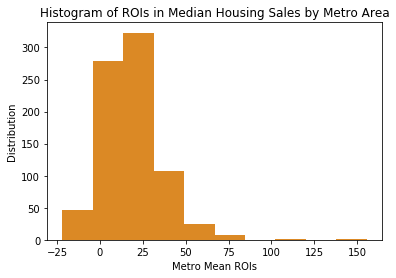

Median ROI: 17.3
Mean ROI: 18.36


In [30]:
#Distribution of Return on Investment
x = df_roi_met['Mean_ROI']

fig3, ax3 = plt.subplots()
ax3.hist(x, color=color2)
ax3.set_xlabel('Metro Mean ROIs')
ax3.set_ylabel('Distribution')
ax3.set_title('Histogram of ROIs in Median Housing Sales by Metro Area')

fig1.tight_layout()
plt.show()
print('Median ROI: {}'.format(round(x.median(), 2)))
print('Mean ROI: {}'.format(round(x.mean(), 2)))

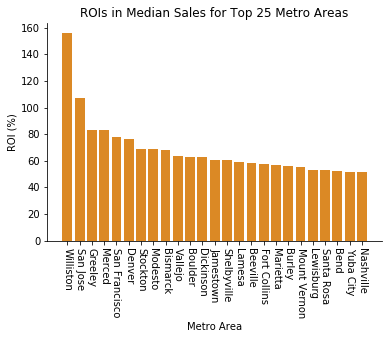

In [31]:
#Bar chart of top 25
top_25_roi = df_roi_met.iloc[0:25]

x = top_25_roi['Metro']
y = top_25_roi['Mean_ROI']

fig4, ax4 = plt.subplots()
ax4.bar(x,y, color=color2)
ax4.set_xlabel('Metro Area')
ax4.set_ylabel('ROI (%)')
ax4.set_title('ROIs in Median Sales for Top 25 Metro Areas')
plt.xticks(rotation=270)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

plt.show()

#### ROI by Metro Area

In [32]:
#selecting top 10 metro areas, then filtering cleaned dataframe
top_10_metro2 = list(top_25_roi[0:10]['Metro'])

top_metro_df2 = clean_df[clean_df['Metro'].isin(top_10_metro2)]

In [33]:
#creating average of median housing sales for each metro
by_metro2 = pd.DataFrame(top_metro_df2.groupby(['Date', 'Metro'])['Median_Housing_Sales'].mean())
by_metro2.reset_index(inplace=True)
by_metro2.set_index('Date', inplace=True)
by_metro_wide2 = by_metro2.pivot(columns='Metro', values='Median_Housing_Sales')

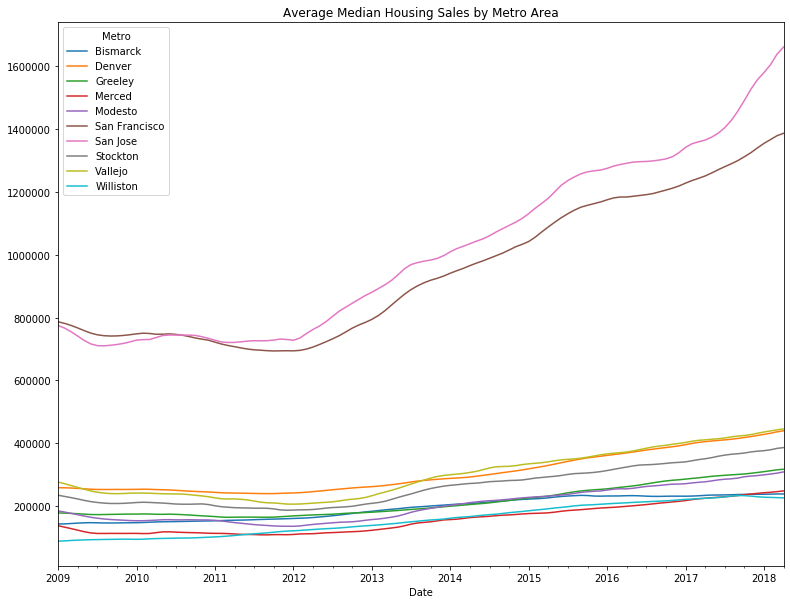

In [34]:
by_metro_wide2.plot(figsize = (13,10), legend=True)
plt.title('Average Median Housing Sales by Metro Area')
plt.savefig('roi_metro_mediansales.png')
plt.show()

When calculating the net profit in median housing sales, you'll find that the average return on investment in median housing sales by metro area was 18.4% (median 17.3%) over the past 9 years. Not accounting for inflation, the following metro areas exhibit the largest returns on investment in median housing sales:

In [35]:
df_roi_met.head(10)

,Metro,State,Mean_ROI
770,Williston,ND,155.656109
633,San Jose,CA,107.459398
280,Greeley,CO,82.892898
452,Merced,CA,82.739365
632,San Francisco,CA,78.109781
188,Denver,CO,76.206190
692,Stockton,CA,68.769423
468,Modesto,CA,68.700254
70,Bismarck,ND,68.344979
730,Vallejo,CA,63.218963


The list is almost identical to the metro areas with the highest profit margins.

#### ROI by Zip code

Again, let's look at the metric of ROI, but by zip code, rather than metro area.

In [36]:
df_roi.sort_values(['ROI'], ascending = False).head(10)

,Zipcode,City,State,Metro,CountyName,SizeRank,Price_paid,Price_sold,Profit_margin,ROI
5665,94301,Palo Alto,CA,San Jose,Santa Clara,5739,1726900.0,4818400.0,64.160302,179.020210
1148,11222,New York,NY,New York,Kings,1156,633600.0,1721100.0,63.186334,171.638258
2560,94043,Mountain View,CA,San Jose,Santa Clara,2581,764700.0,2074900.0,63.145212,171.335164
472,11216,New York,NY,New York,Kings,476,610900.0,1598700.0,61.787703,161.695859
6473,15201,Pittsburgh,PA,Pittsburgh,Allegheny,6564,70900.0,185200.0,61.717063,161.212976
1781,94040,Mountain View,CA,San Jose,Santa Clara,1792,1093700.0,2839500.0,61.482655,159.623297
2451,80010,Aurora,CO,Denver,Arapahoe,2471,107000.0,277600.0,61.455331,159.439252
115,11211,New York,NY,New York,Kings,118,631700.0,1623700.0,61.095030,157.036568
2433,58801,Williston,ND,Williston,Williams,2453,88400.0,226000.0,60.884956,155.656109
2140,80204,Denver,CO,Denver,Denver,2156,146900.0,371600.0,60.468245,152.961198


This is the exact same top 10 zipcodes we saw for those with the highest profit margins, with two zipcodes having swapped their order.

# Time Series Modeling

As we'll be creating models for each individual zip code and forecasting from there, it's important that we use the analyses generated in the EDA section to inform our decision of which zip codes to investigate further. I'm going to use the top 10 zip codes for profit margin (which also happen to be the top 10 for ROI) and create models for each of them.

In [37]:
#Top 10 zipcodes
mod_1_zips = top_10_pm_zips

In [38]:
#creating df for modeling
m1 = clean_df[clean_df.Zipcode.isin(mod_1_zips)]

#### Splitting dataframes

In [39]:
def split_df(df):
    """This function takes a dataframe and splits it into multiple dataframes based off the
    zip code and returns a list of dataframes as well as a list of the zipcodes in order.
    These new dataframes have also had every column removed except for the 
    'Median_Housing_Sales' column.
    
    Parameters:
    dataframe = df
    """
    
    unique_zips = list(df.Zipcode.unique())
    
    zip_dfs = []
    
    for zipcode in unique_zips:
        new_df = df[df['Zipcode'] == zipcode]['Median_Housing_Sales']
        zip_dfs.append(new_df)
    
    return zip_dfs, unique_zips

In [40]:
m1_dfs, m1_order = split_df(m1)

#### Autocorrelation

We know that our data exhibits a positive trend, visible from the line graphs plotted above. This means we'll need to difference our data, but before we do, lets look at the autocorrelation plots just to be sure.

In [41]:
def auto_corr(list_dfs, order):
    """This function takes a list of dataframes and the order of each zipcode for that 
    dataframe and returns autocorrelation plots for each.
    
    Parameters:
    list_dfs = list of time series dataframes
    order = order of zipcodes for the list of dataframes"""
    
    for i in range(len(order)):
        print("Autocorrelation plots for {}".format(order[i]))
        plot_acf(list_dfs[i])
        plt.show()

Autocorrelation plots for 11211


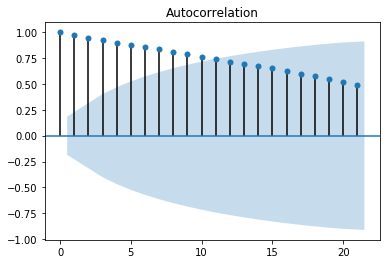

Autocorrelation plots for 11216


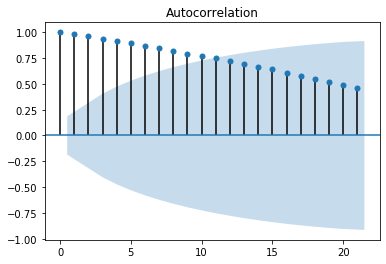

Autocorrelation plots for 11222


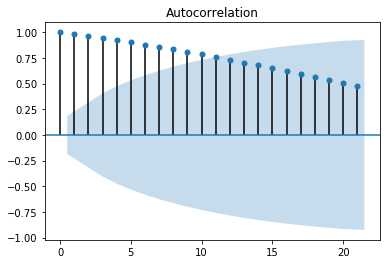

Autocorrelation plots for 94040


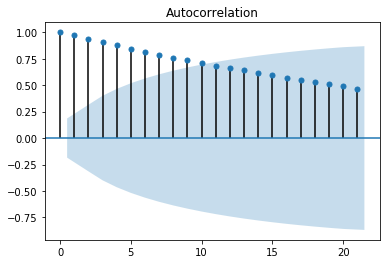

Autocorrelation plots for 80204


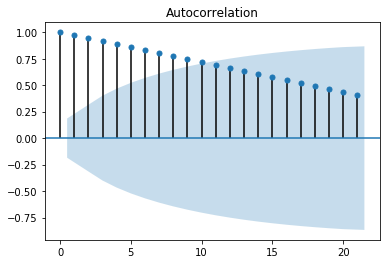

Autocorrelation plots for 58801


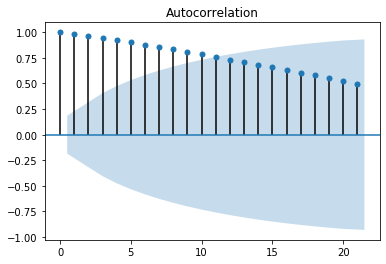

Autocorrelation plots for 80010


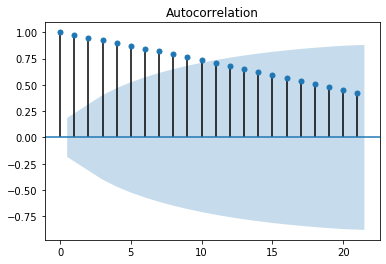

Autocorrelation plots for 94043


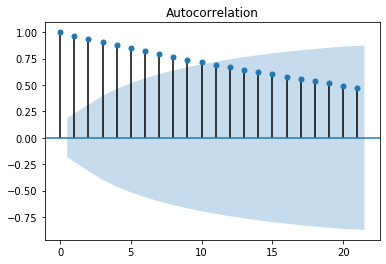

Autocorrelation plots for 94301


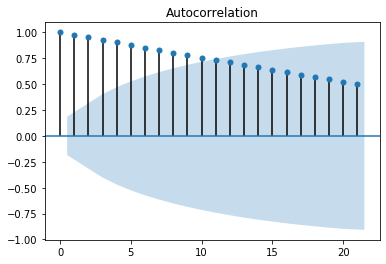

Autocorrelation plots for 15201


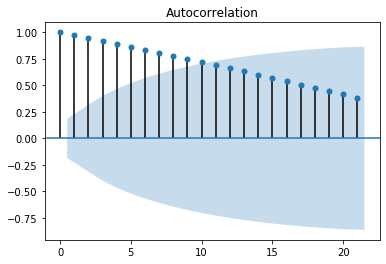

In [42]:
auto_corr(m1_dfs, m1_order)

#### Initial Modeling

In [43]:
def arima_model_1(list_dfs, order):
    """This function takes each time series in a list of dataframes, splits them into
    train/test data, and then fits them to a basic pdq = (1,1,1) ARIMA model. Then we visualize
    the test data and predictions to get a sense of how well the model performed.
    
    Parameters:
    list_dfs = list of time series dataframes
    order = order of zipcodes for the list of dataframes"""
    
    for i in range(len(order)):
        X = list_dfs[i].values
        train = X[0:90]
        test = X[90:112]
        
        model_arima = ARIMA(train, order=(1,1,1))
        model_arima_fit = model_arima.fit()
        predictions= model_arima_fit.forecast(steps=22)[0]
        
        print("Predictions vs Test Data for {}".format(order[i]))
        print("AIC Score: {}".format(model_arima_fit.aic))
        print("\n")
        
        plt.plot(test)
        plt.plot(predictions, color = "red")
        plt.show()

Predictions vs Test Data for 11211
AIC Score: 1841.5289054810971




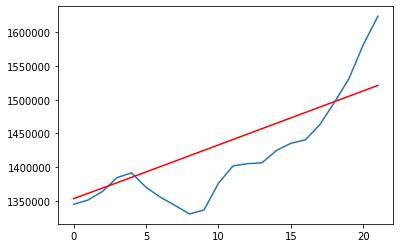

Predictions vs Test Data for 11216
AIC Score: 1771.2549799978356




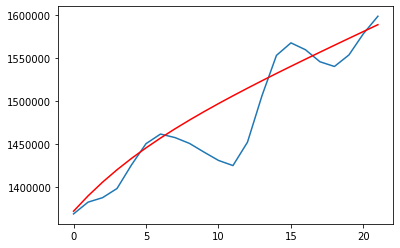

Predictions vs Test Data for 11222
AIC Score: 1841.5359628784763




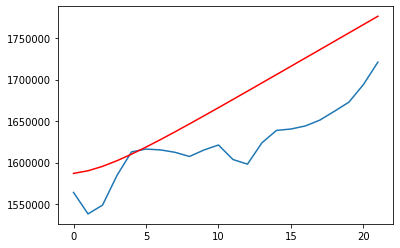

Predictions vs Test Data for 94040
AIC Score: 1749.2597768749256




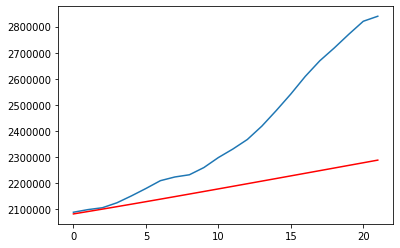

Predictions vs Test Data for 80204
AIC Score: 1362.239576960895




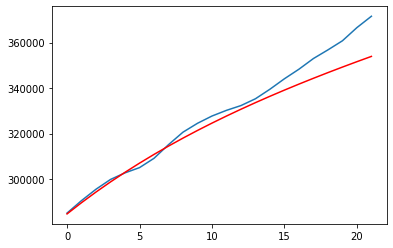

Predictions vs Test Data for 58801
AIC Score: 1297.0239476186598




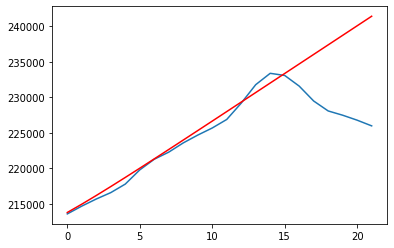

Predictions vs Test Data for 80010
AIC Score: 1332.554782076666




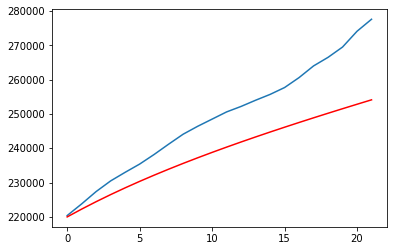

Predictions vs Test Data for 94043
AIC Score: 1724.954893415449




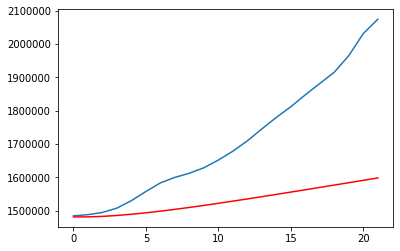

Predictions vs Test Data for 94301
AIC Score: 1875.2367104183463




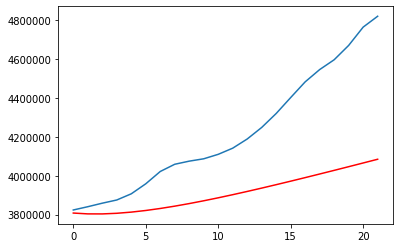

Predictions vs Test Data for 15201
AIC Score: 1341.0669165770637




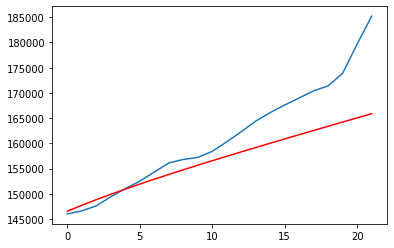

In [44]:
arima_model_1(m1_dfs, m1_order)

We can see from these graphs that the models need to be adjusted. We can do that by changing the pdq parameters.

#### Adjusting Parameters

In [45]:
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

In [46]:
def model_tuning(list_dfs, order, pdq):
    """This function takes each time series in a list of dataframes, splits them into
    train/test data, and then fits them to a range of pdq values in order to generate the best
    ARIMA model.
    
    Parameters:
    list_dfs = list of time series dataframes
    order = order of zipcodes for the list of dataframes
    pdq = list of varying pdq values"""
    
    new_dfs = []
    
    for i in range(len(order)):
        X = list_dfs[i].values
        train = X[0:90]
        test = X[90:112]
        
        aics = {}
        
        for param in pdq:
            try:
                model_arima = ARIMA(train,order=param)
                model_arima_fit = model_arima.fit()
                aics[param] = model_arima_fit.aic
            except:
                continue
    
        df = pd.DataFrame({"zipcode": order[i],
                    "params": list(aics.keys()),
                    "aics": list(aics.values())})
        
        new_dfs.append(df)
        merged_df = pd.concat(new_dfs)
    return merged_df

In [47]:
#trying all different iterations of pdq values for all zipcodes
m1_params = model_tuning(m1_dfs, m1_order, pdq)

In [48]:
#determining pdq values for lowest aic score
m1_min_aics = m1_params.dropna().groupby(['zipcode'])['aics'].min().reset_index()

def pdq_values(df, aic_df):
    """This function returns the pdq values for the lowest aics score for each zipcode.
    
    Parameters:
    df = dataframe of all zipcode, pdq, and aic combinations
    aic_df = dataframe of lowest aic score for each zipcode"""
    
    zips = list(aic_df['zipcode'])
    aics = list(aic_df['aics'])
    
    for i in range(len(zips)):
        filtered = df[df['zipcode'] == zips[i]]
        best_params = list(filtered[filtered['aics'] == aics[i]]['params'])
        print("Best params for {} zip code are: {}".format(zips[i], best_params))

In [49]:
pdq_values(m1_params, m1_min_aics)

Best params for 11211 zip code are: [(1, 2, 3)]
Best params for 11216 zip code are: [(3, 2, 4)]
Best params for 11222 zip code are: [(1, 2, 3)]
Best params for 15201 zip code are: [(1, 2, 3)]
Best params for 58801 zip code are: [(2, 2, 0)]
Best params for 80010 zip code are: [(3, 2, 3)]
Best params for 80204 zip code are: [(3, 2, 4)]
Best params for 94040 zip code are: [(1, 2, 3)]
Best params for 94043 zip code are: [(3, 2, 2)]
Best params for 94301 zip code are: [(1, 2, 3)]


#### Round 2 Models

In [50]:
print(m1_order)

[11211, 11216, 11222, 94040, 80204, 58801, 80010, 94043, 94301, 15201]


In [51]:
m1_final_params = [(1,2,3), (3,2,4), (1,2,3), (1,2,3), (3,2,4), (2,2,0), (3,2,3), (3,2,2), (1,2,3), (1,2,3)]

In [52]:
#adjusting the arima model function
def arima_model_2(list_dfs, order, pdqs):
    """This function takes each time series in a list of dataframes, splits them into
    train/test data, and then fits them to a basic pdq = (1,1,1) ARIMA model. Then we visualize
    the test data and predictions to get a sense of how well the model performed.
    
    Parameters:
    list_dfs = list of time series dataframes
    order = order of zipcodes for the list of dataframes
    pdqs = list of best parameters for each zipcode"""
    
    for i in range(len(order)):
        X = list_dfs[i].values
        train = X[0:90]
        test = X[90:112]
        
        model_arima = ARIMA(train, order=pdqs[i])
        model_arima_fit = model_arima.fit()
        
        fc, se, conf = model_arima_fit.forecast(22, alpha=0.05)
        fc_series = pd.Series(fc, index=list(range(90,112)))
        lower_series = pd.Series(conf[:, 0], index=list(range(90,112)))
        upper_series = pd.Series(conf[:, 1], index=list(range(90,112)))
        test_series = pd.Series(test, index=list(range(90,112)))
        
        print("Predictions vs Test Data for {}".format(order[i]))
        print("AIC Score: {}".format(model_arima_fit.aic))
        
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(train, label='training')
        plt.plot(test_series, label='actual')
        plt.plot(fc_series, label='forecast')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='k', alpha=.15)
        plt.title('Forecast vs Actuals')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()

Predictions vs Test Data for 11211
AIC Score: 1803.0324702268845


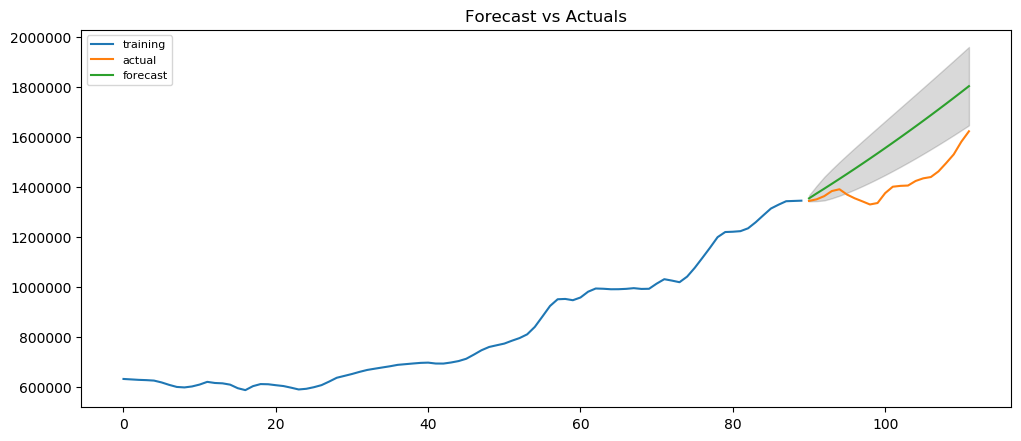

Predictions vs Test Data for 11216
AIC Score: 1703.424747075283


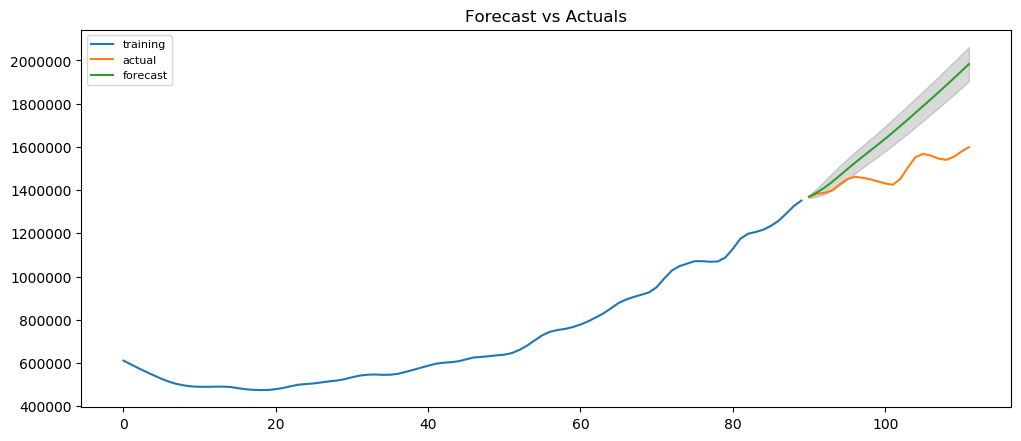

Predictions vs Test Data for 11222
AIC Score: 1798.48176799173


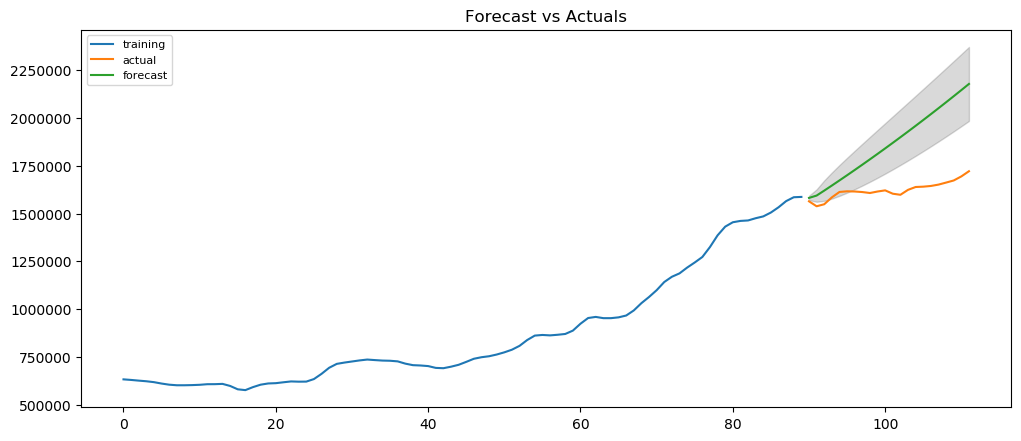

Predictions vs Test Data for 94040
AIC Score: 1717.0010463461963


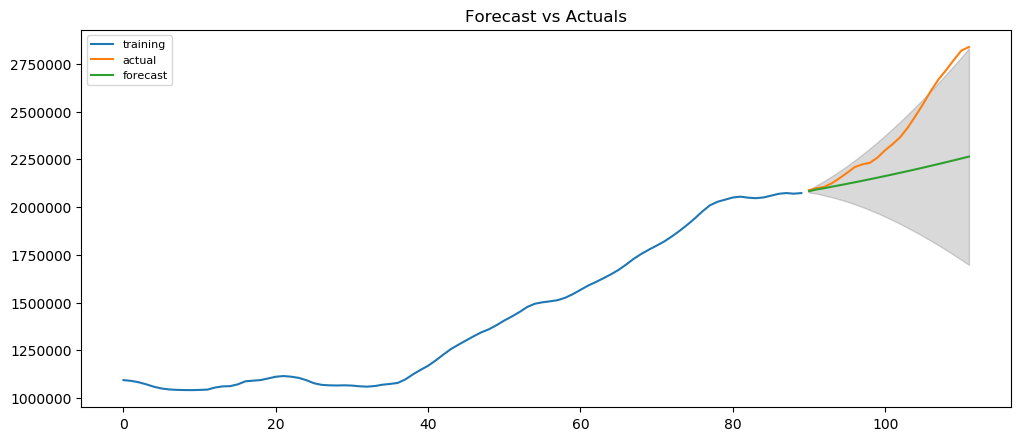

Predictions vs Test Data for 80204
AIC Score: 1331.4245891933924


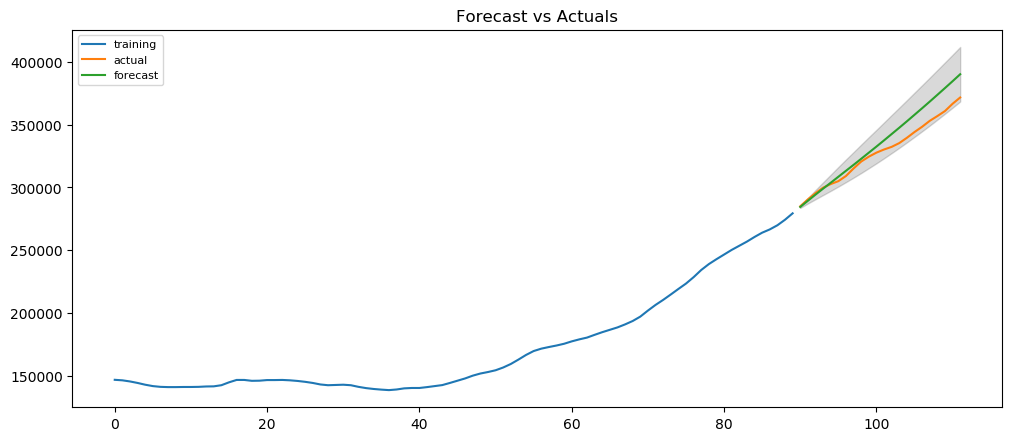

Predictions vs Test Data for 58801
AIC Score: 1262.0723712785862


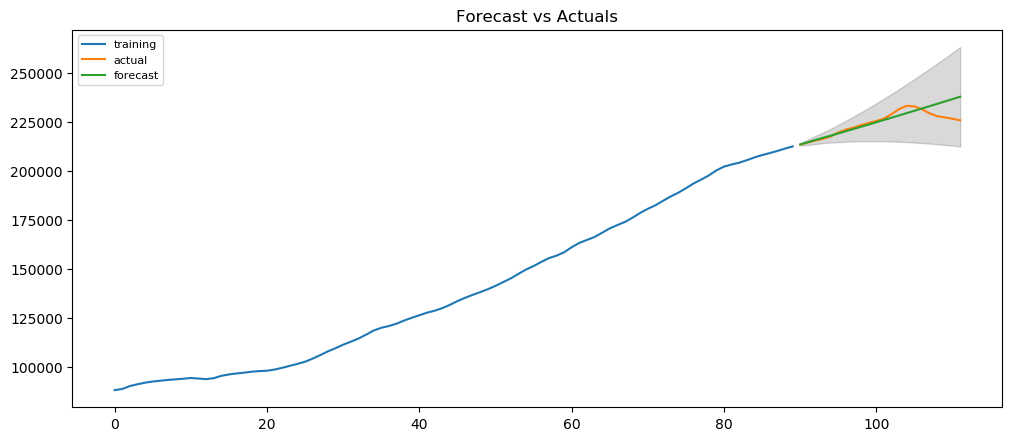

Predictions vs Test Data for 80010
AIC Score: 1296.4116906125964


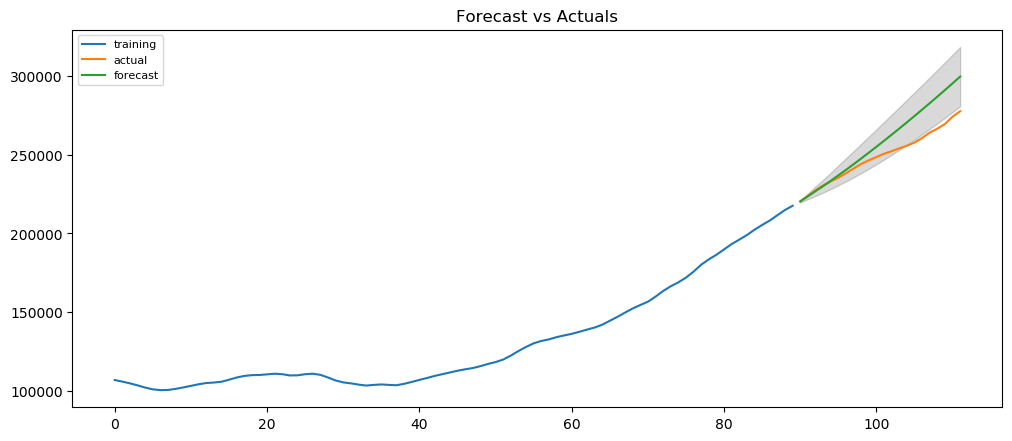

Predictions vs Test Data for 94043
AIC Score: 1677.8249933283942


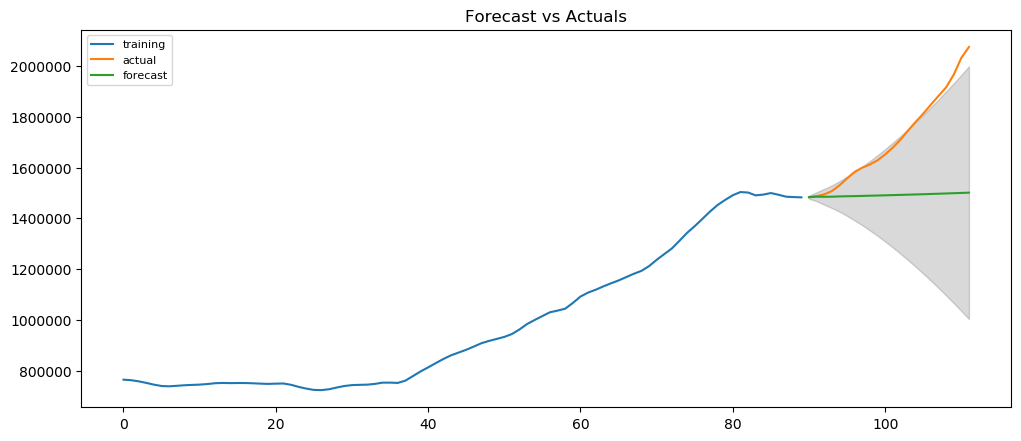

Predictions vs Test Data for 94301
AIC Score: 1827.2078384239612


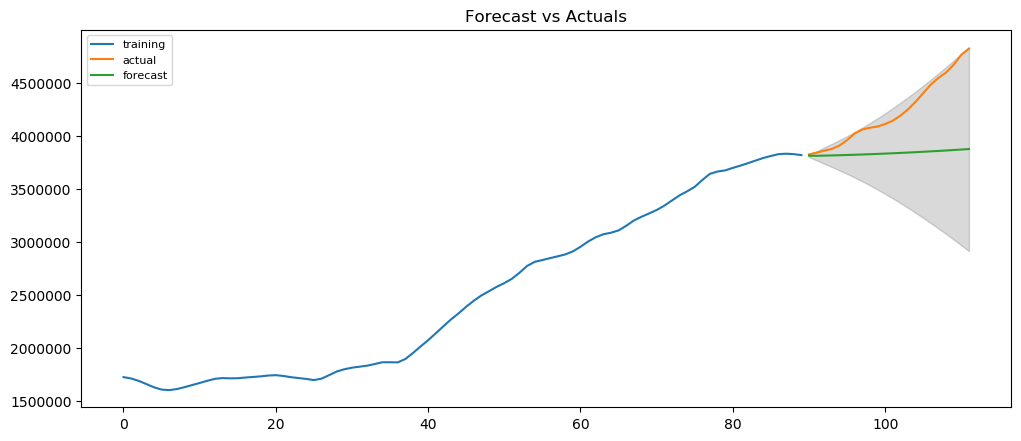

Predictions vs Test Data for 15201
AIC Score: 1304.7620952690245


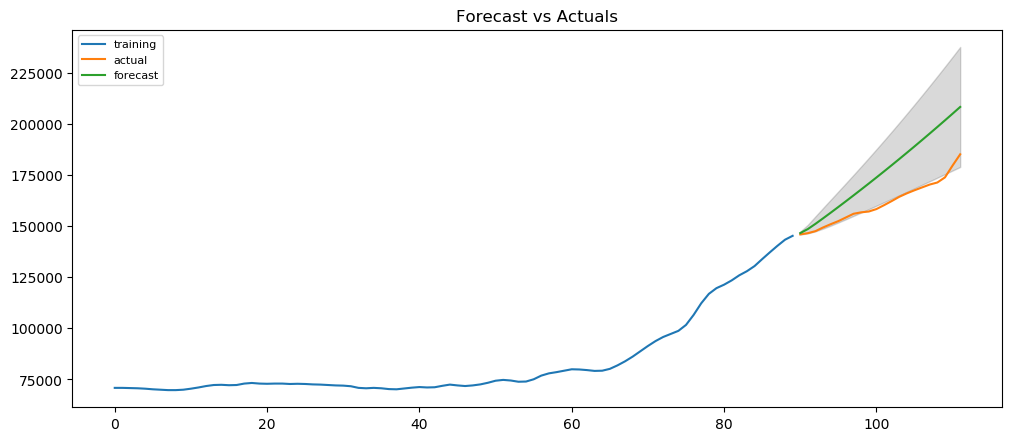

In [53]:
#second round models
arima_model_2(m1_dfs, m1_order, m1_final_params)

Looking at the forecasted values for some of these models, we can see that several of them are still a bit off in terms of accurately predicting median housing sales. A lot of this is due to where the train/test split occurs, the test data usually takes on a different trend than where the training data left off. The following zip codes are where that occurs:
    1. 11211
    2. 11216
    3. 11222
    4. 94040
    5. 94043
    6. 94301
I want to try running the models again, but this time without the train/test split.

#### Round 3 Models

In [54]:
def model_tuning_2(list_dfs, order, pdq):
    """This function takes each time series in a list of dataframes, splits them into
    train/test data, and then fits them to a range of pdq values in order to generate the best
    ARIMA model.
    
    Parameters:
    list_dfs = list of time series dataframes
    order = order of zipcodes for the list of dataframes
    pdq = list of varying pdq values"""
    
    new_dfs = []
    
    for i in range(len(order)):
        X = list_dfs[i].values
        
        aics = {}
        
        for param in pdq:
            try:
                model_arima = ARIMA(X,order=param)
                model_arima_fit = model_arima.fit()
                aics[param] = model_arima_fit.aic
            except:
                continue
    
        df = pd.DataFrame({"zipcode": order[i],
                    "params": list(aics.keys()),
                    "aics": list(aics.values())})
        
        new_dfs.append(df)
        merged_df = pd.concat(new_dfs)
    return merged_df

In [55]:
#trying all different iterations of pdq values for all zipcodes in both models
m3_params = model_tuning_2(m1_dfs, m1_order, pdq)

In [56]:
#determining pdq values for lowest aic score
m3_min_aics = m3_params.dropna().groupby(['zipcode'])['aics'].min().reset_index()

pdq_values(m3_params, m3_min_aics)

Best params for 11211 zip code are: [(2, 2, 3)]
Best params for 11216 zip code are: [(2, 2, 4)]
Best params for 11222 zip code are: [(4, 2, 4)]
Best params for 15201 zip code are: [(1, 2, 3)]
Best params for 58801 zip code are: [(0, 2, 3)]
Best params for 80010 zip code are: [(4, 2, 3)]
Best params for 80204 zip code are: [(3, 2, 4)]
Best params for 94040 zip code are: [(4, 2, 4)]
Best params for 94043 zip code are: [(4, 2, 3)]
Best params for 94301 zip code are: [(4, 2, 3)]


In [57]:
m3_final_params = [(2,2,3), (2,2,4), (4,2,4), (4,2,4), (3,2,4), (0,2,3), (4,2,3), (4,2,3), (4,2,3), (1,2,3)]

In [58]:
#adjusting the arima model function
def arima_model_3(list_dfs, order, pdqs):
    """This function takes each time series in a list of dataframes, splits them into
    train/test data, and then fits them to a basic pdq = (1,1,1) ARIMA model. Then we visualize
    the test data and predictions to get a sense of how well the model performed.
    
    Parameters:
    list_dfs = list of time series dataframes
    order = order of zipcodes for the list of dataframes
    pdqs = list of best parameters for each zipcode"""
    
    for i in range(len(order)):
        X = list_dfs[i].values
        
        model_arima = ARIMA(X, order=pdqs[i])
        model_arima_fit = model_arima.fit()
        
        fc, se, conf = model_arima_fit.forecast(24, alpha=0.05)
        fc_series = pd.Series(fc, index=list(range(112,136)))
        lower_series = pd.Series(conf[:, 0], index=list(range(112,136)))
        upper_series = pd.Series(conf[:, 1], index=list(range(112,136)))
        
        print("Forecast Trend for {}".format(order[i]))
        print("AIC Score: {}".format(model_arima_fit.aic))
        
        plt.figure(figsize=(12,5), dpi=100)
        plt.plot(X, label='actual')
        plt.plot(fc_series, label='forecast')
        plt.fill_between(lower_series.index, lower_series, upper_series, 
                         color='k', alpha=.15)
        plt.title('24-Month Forecast')
        plt.legend(loc='upper left', fontsize=8)
        plt.show()

Forecast Trend for 11211
AIC Score: 2283.9945757616606


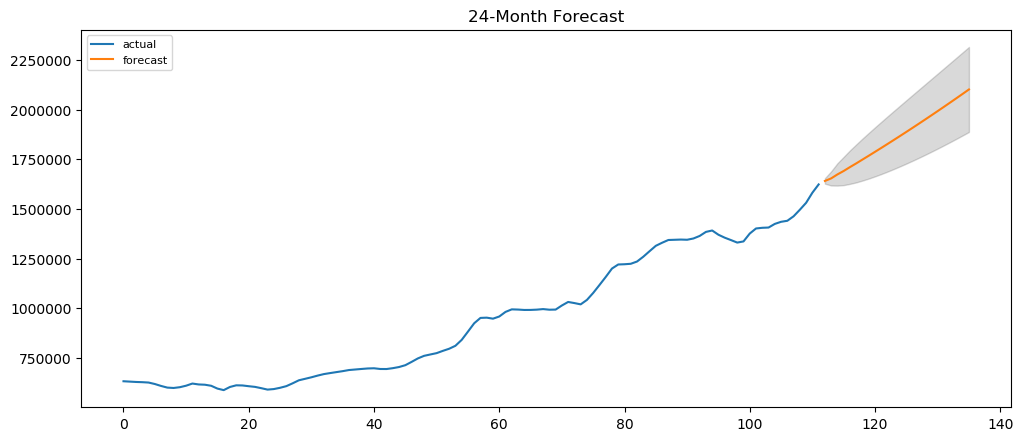

Forecast Trend for 11216
AIC Score: 2193.5355708119114


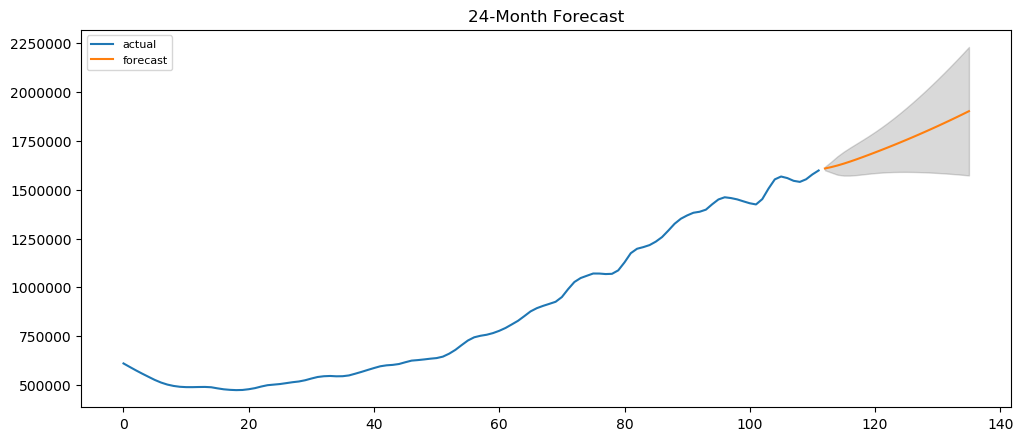

Forecast Trend for 11222
AIC Score: 2270.2154246629207


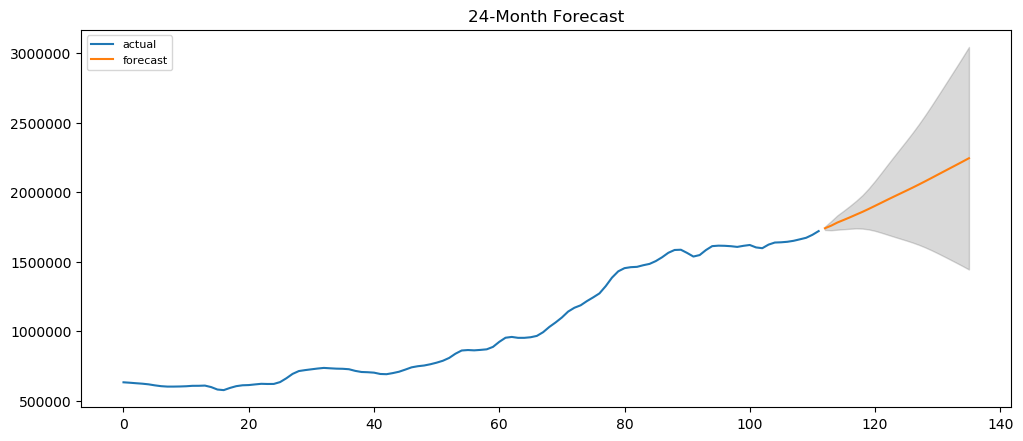

Forecast Trend for 94040
AIC Score: 2190.5698219967785


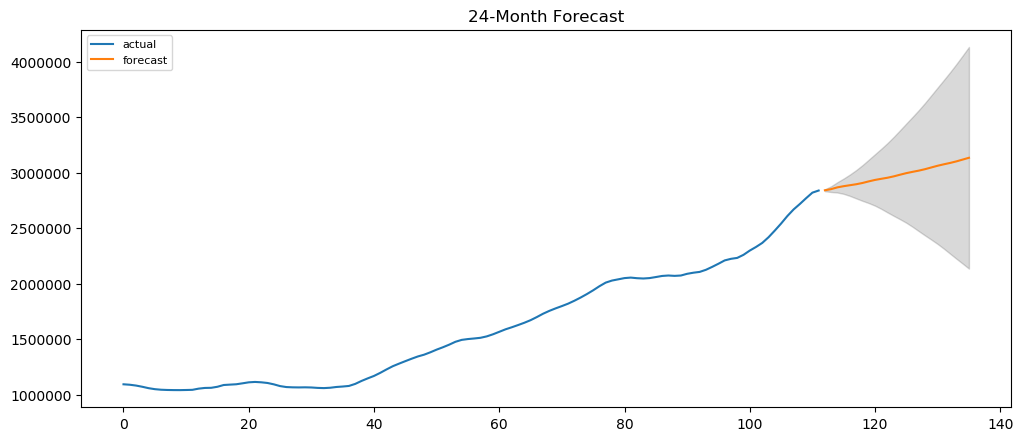

Forecast Trend for 80204
AIC Score: 1693.5575992633326


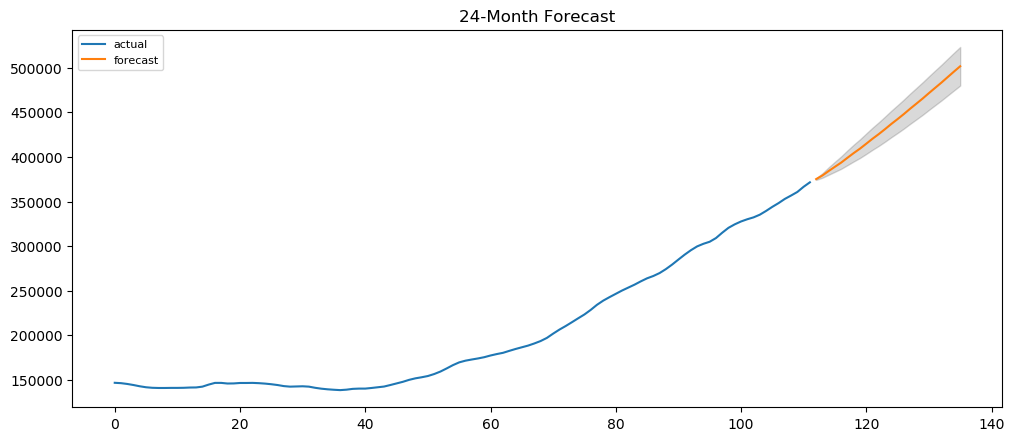

Forecast Trend for 58801
AIC Score: 1621.9372345396846


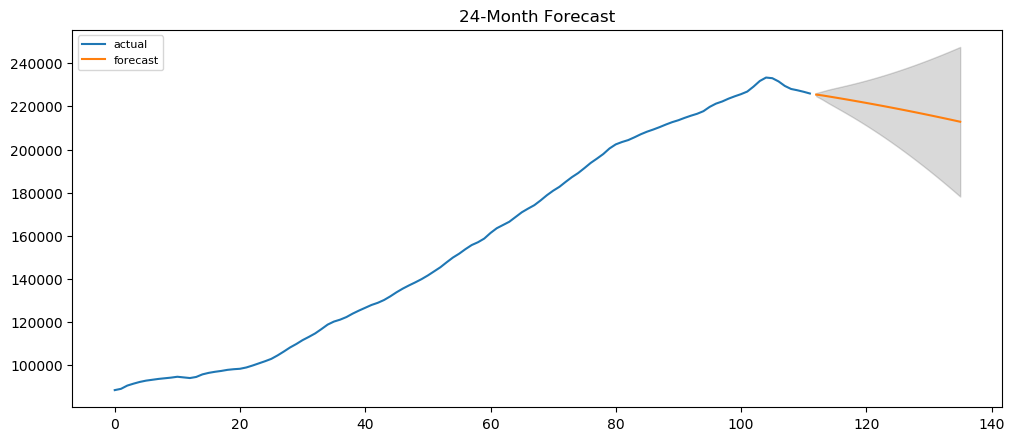

Forecast Trend for 80010
AIC Score: 1639.4684764935844


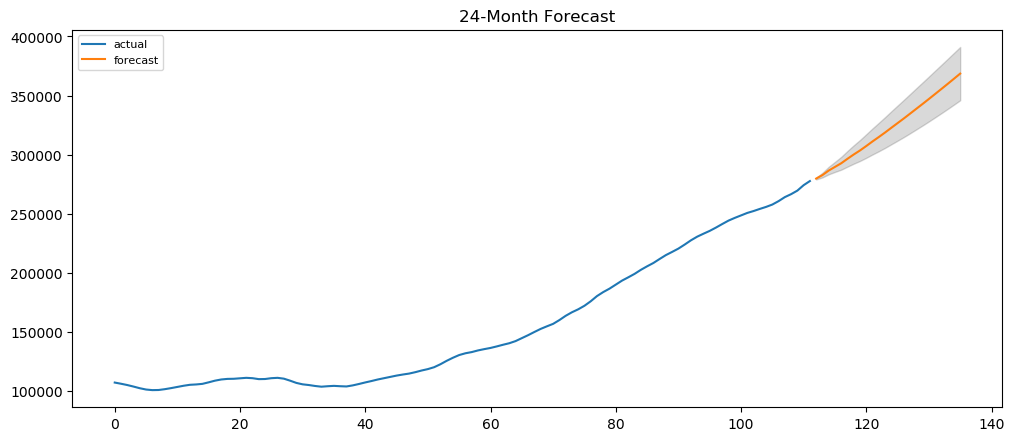

Forecast Trend for 94043
AIC Score: 2138.864645071194


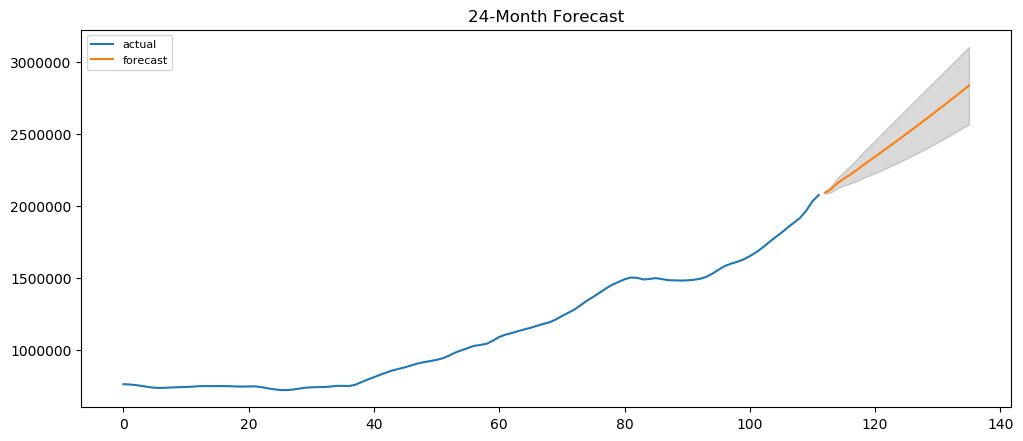

Forecast Trend for 94301
AIC Score: 2307.5222326129824


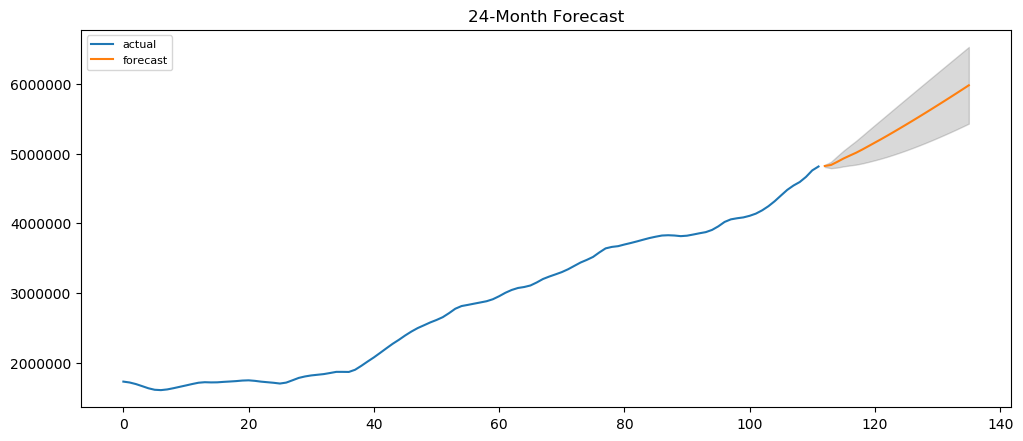

Forecast Trend for 15201
AIC Score: 1674.4758473266984


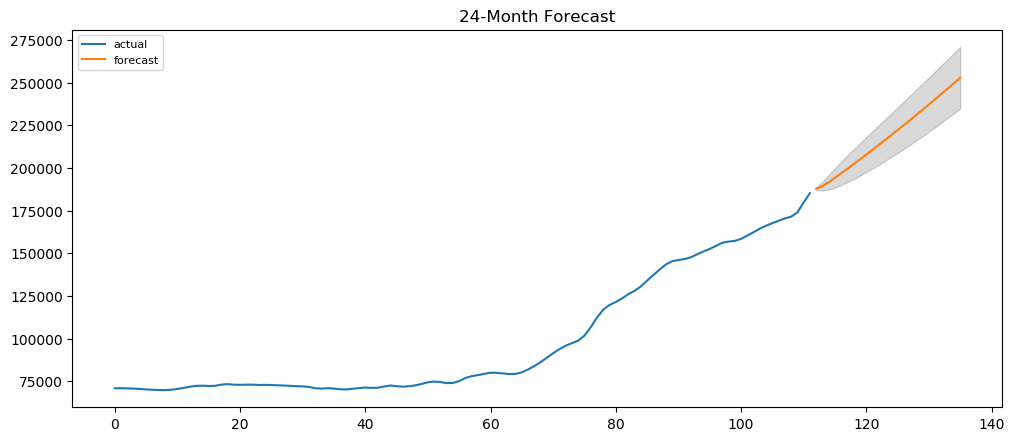

In [59]:
arima_model_3(m1_dfs, m1_order, m3_final_params)

# Step 6: Interpreting Results

In [60]:
def predictions(df, zipcode, pdq, timeline, pm=1):
    """This function creates the ideal model for a zipcode, then predicts mean housing sales sales over a given
    timeline.
    
    Parameters:
    df = time series dataframe
    zipcode = zipcode for current model
    pdq = best pdq parameters for this zipcode
    timeline (int) = number of months past end of data you want prediction (data ends '2018-04-01')
    pm = 1 if calculating profit margin, 0 if calculating net profit"""
    
    X = df.values
        
    model_arima = ARIMA(X, order=pdq)
    model_arima_fit = model_arima.fit()
    predictions = model_arima_fit.forecast(steps = timeline)[0]
        
    start_value = list(X[111:])*timeline
    dates = list(pd.date_range('2018-05', periods=timeline, freq='M'))
    df_values = pd.DataFrame({'dates':dates,
                              'zipcode': zip_code,
                             'start_value':start_value,
                             'predicted_values':predictions})
    df_values.set_index('dates', inplace=True)
    df_values['profit_margin'] = ((df_values.predicted_values - df_values.start_value)/df_values.predicted_values)*100
    df_values['roi'] = ((df_values.predicted_values - df_values.start_value) / df_values.start_value)*100
    
    return df_values

#### One-Year Predictions

In [61]:
#predicting median housing sales one year out
one_year = []

for i in range(len(m1_dfs)):
    df = m1_dfs[i]
    zip_code = m1_order[i]
    pdq = m3_final_params[i]
    preds = predictions(df, zip_code, pdq, timeline=12)
    one_year.append(preds)

In [62]:
one_year_df = pd.concat(one_year)
one_year_df['2019-04'].sort_values(['roi'], ascending = False)

,zipcode,start_value,predicted_values,profit_margin,roi
dates,,,,,
2019-04-30,94043,2074900.0,2.434783e+06,14.780890,17.344572
2019-04-30,15201,185200.0,2.162739e+05,14.367859,16.778582
2019-04-30,80204,371600.0,4.312043e+05,13.822745,16.039900
2019-04-30,80010,277600.0,3.186768e+05,12.889789,14.797105
2019-04-30,11222,1721100.0,1.968661e+06,12.575099,14.383888
2019-04-30,11211,1623700.0,1.847635e+06,12.120074,13.791629
2019-04-30,94301,4818400.0,5.314471e+06,9.334336,10.295338
2019-04-30,11216,1598700.0,1.728740e+06,7.522242,8.134109
2019-04-30,94040,2839500.0,2.967182e+06,4.303142,4.496638


#### Three-Year Predictions

In [63]:
#predicting median housing sales one year out
three_year = []

for i in range(len(m1_dfs)):
    df = m1_dfs[i]
    zip_code = m1_order[i]
    pdq = m3_final_params[i]
    preds = predictions(df, zip_code, pdq, timeline=36)
    three_year.append(preds)

In [64]:
three_year_df = pd.concat(three_year)
three_year_df['2021-04'].sort_values(['roi'], ascending = False)

,zipcode,start_value,predicted_values,profit_margin,roi
dates,,,,,
2021-04-30,15201,185200.0,2.932653e+05,36.848981,58.350571
2021-04-30,94043,2074900.0,3.271352e+06,36.573624,57.663114
2021-04-30,80204,371600.0,5.797897e+05,35.907792,56.025207
2021-04-30,80010,277600.0,4.238889e+05,34.511146,52.697741
2021-04-30,11222,1721100.0,2.554847e+06,32.633932,48.442685
2021-04-30,11211,1623700.0,2.382314e+06,31.843579,46.721320
2021-04-30,94301,4818400.0,6.720425e+06,28.302158,39.474212
2021-04-30,11216,1598700.0,2.110679e+06,24.256617,32.024733
2021-04-30,94040,2839500.0,3.327454e+06,14.664487,17.184507


## Summary

The median housing sales by zip code dataset provided by Zillow is a little too simple to provide robust predictions on future housing sales. There are a lot of factors to consider when investing in real estate:

1. **Resale value**, which can be affected by:
    - proximity to amenities like grocery stores, transit lines, entertainment venues, etc.
    - economic growth within the community; are there a lot of available jobs
    - status of local schools and other opportunities for education

    
2. **Risk**, which is measured by:
    - increasing vacancies
    - declining rents
    - economic downturn
    
And with these factors come other considerations. How long do you plan to own the property? Do you plan to fix up the house and resell? Or do you plan to just buy and hold the property for a longer time frame, selling it once the price has increased a substantial amount?

With all these things in mind, you can see why this particular dataset is a little too simple for predicting solid investments. What with only providing the historical median housing sales by zip code, it's hard to calculate things like risk or account for factors that might affect resale value, like economic growth and proximity to amenities.

However, we can still come to some reasonable, albeit simplified, recommendations for real estate investments. 

#### Top Five Zip Codes for Investment
Although our data exploration looked at two different variables, return on investment (ROI) and profit margin, they both lead to the same top zip codes. The top 10 zip codes with the highest ROIs were the same zip codes with the largest profit margins. This makes sense, as we're only dealing with two separate values, how much the property was purchased for and for how much it was sold. Were we to have access to other variables like annual property tax, realtor fees, and any other costs that might be associated with buying and selling property, the two lists might have looked a little different. With this in mind, we should consider the following as **gross** ROIs, and not **net**, as they certainly don't account for all the cost associated with these transactions.

When considering ROIs, I recommend the following zip codes for investment opportunities.

**One Year**

1. **94043** - Mountain View, CA - 17.3% ROI
2. **15201** - Pittsburgh, PA - 16.8% ROI
3. **80204** - Denver, CO - 16.0% ROI 
4. **80010** - Aurora, CO - 14.8% ROI
5. **11222** - New York City, NY - 14.4% ROI

**Three Years**

2. **15201** - Pittsburgh, PA - 58.4% ROI
1. **94043** - Mountain View, CA - 57.7% ROI
3. **80204** - Denver, CO - 56.0% ROI 
4. **80010** - Aurora, CO - 52.7% ROI
5. **11222** - New York City, NY - 48.4% ROI

I think it's best to base investment decisions off the one-year predictions, as the model will have more uncertainty the farther out you forecast.

#### Future Analyses

By pairing the Zillow dataset with other datasets, like Census data, economic growth, and other housing datasets that include additional data related to risk, profitability, and proximity, you'd be able to create a much more robust model and be able to recommend better potential targets for investment.